# Genetic Algorithm for Feature Selection

A Genetic Algorithm for feature selection is an evolutionary approach inspired by natural selection for selecting optimal feature subsets. The steps involve:

1. Initialization: Generate an initial population of random feature subsets.
2. Evaluation: Train a model using each feature subset and evaluate its performance 
3. Selection: Choose the best-performing feature subsets as parents for the next generation.
4. Crossover: Combine pairs of parent feature subsets to create offspring by mixing their features.
5. Mutation: Introduce small random changes to some offspring to maintain diversity and avoid local optima.
6. Replacement: Replace the worst-performing feature subsets in the population with the new offspring.
7. Iteration: Repeat the process until a stopping criterion is met

Genetic Algorithms can capture complex, non-linear relationships between features, can be used with any type of model, and perform a comprehensive search of the feature space. The script is adapted from the tutorial found here https://medium.com/@ela.markovic/feature-selection-using-genetic-algorithm-complete-beginner-friendly-guide-198496393728 


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from scipy.stats import ttest_rel
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, SVC
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import random
from tqdm import tqdm
import os
import glob

### Hyperparameters

In [2]:
# Minimum number of features an individual (a molecule) can have
min_features = 10 
# Maximum number of features an individual (a molecule) can have
max_features = 100 

# The number of individuals in the population. This determines how many candidate solutions
# (feature subsets) are considered in each generation.
population_size = 100 

max_iterations = 50 # Maximum number of generations

# The percentage of the population that will be preserved as elite. Elite individuals
# are kept without change and passed directly to the next generation.
elite_percent = 0.6 

# The probability that a mutation will occur in an individual. Mutation introduces variability
# by flipping feature selections (0 to 1 or 1 to 0) within the individual.
mutation_probability = 0.01 # Probability of mutation

patience = 15  # For early stopping
reevaluation_interval = 10  # Re-evaluate elites every 10 generations

model_types = ['svm','linear_regression', 'random_forest', 'xgboost'] # List of model types to iterate over
problem_types = ['classification','regression']

## Functions to use

### Create an initial population (step 1)

In [3]:
# Function to generate random individuals (feature subsets)
def generate_random_individuals(population_size, num_features, min_features, max_features):
    """
    Generate a population of random individuals represented as binary vectors.

    Parameters:
    population_size (int): Number of individuals in the population.
    num_features (int): Total number of features available.
    min_features (int): Minimum number of features to include in an individual.
    max_features (int): Maximum number of features to include in an individual.

    Returns:
    np.ndarray: A 2D array where each row is a binary vector representing an individual.
    """
    # Initialize the matrix with zeros. if a feature (column) in a population (row) is selected, it will be changed to 1
    individuals = np.zeros((population_size, num_features)) 
    # Loop over the population (in this case, the compounds) and randomly select a set of features to keep 
    for i in range(population_size):
        # Generate a random number of ones (random number of features to keep), which is between min_features and max_features
        num_ones = np.random.randint(min_features, max_features + 1)
        # Randomly assign the ones to features describing the compounds
        ones_indices = np.random.choice(num_features, num_ones, replace=False) #indices that the ones will be assigned to
        individuals[i, ones_indices] = 1 #assign the ones at the indices
    return individuals

### Train a model on every chromosome from the population and calculate accuracy (steps 2 & 3)

This `train_model` function is designed to train a specified regression model, evaluate its performance using cross-validation, and calculate an average R² score to assess model reliability. It starts by selecting only the predictor features specified by predictor_names from the training and test datasets. Based on the model type provided (`random_forest`, `xgboost`, `linear_regression`, or `svr`), the function initializes a model with built-in regularization to prevent overfitting: it limits tree depth in `RandomForestRegressor`, applies both L1 and L2 regularization terms in `XGBRegressor`, uses Ridge (L2) regularization for linear regression, and sets a regularization parameter `C` for `SVR`.

The function then performs 5-fold cross-validation on the training data, obtaining an average R² score (`avg_cv_r2`) that provides a reliable performance estimate by reducing potential overfitting to any single subset of data. After cross-validation, the model is fit on the full training set and used to predict on the test set, yielding a test R² score (`test_r2`). Finally, an overall performance score (`final_score`) is calculated by averaging the cross-validation and test R² scores, giving a balanced measure of how well the model generalizes to new data.

In [4]:
def train_model(x_train, x_test, y_train, y_test, predictor_names, model_type, problem_type):
    """
    Train a specified model and calculate both loss and accuracy.

    Parameters:
    x_train (pd.DataFrame): Training feature set.
    x_test (pd.DataFrame): Test feature set.
    y_train (pd.Series): Training target values.
    y_test (pd.Series): Test target values.
    predictor_names (list): List of feature names to include in the model.
    model_type (str): The type of model ('random_forest', 'xgboost', 'linear_regression', 'svm').
    problem_type (str): The problem type ('regression' or 'classification').

    Returns:
    tuple: Loss (float) and accuracy (float).
    """
    # Split training data into train and validation sets
    x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
        x_train.loc[:, predictor_names], y_train, test_size=0.2)

    # Initialize the model based on the type
    if problem_type == 'regression':
        if model_type == 'random_forest':
            mdl = RandomForestRegressor(random_state=1, max_depth=10, min_samples_split=5, min_samples_leaf=2)
        elif model_type == 'xgboost':
            mdl = XGBRegressor()
        elif model_type == 'linear_regression':
            mdl = Ridge(alpha=1.0)
        elif model_type == 'svm':
            mdl = SVR(C=1.0)
        else:
            raise ValueError("Unsupported regression model type.")
            
    elif problem_type == 'classification':
        if model_type == 'random_forest':
            mdl = RandomForestClassifier(random_state=1, max_depth=10, min_samples_split=5, min_samples_leaf=2)
        elif model_type == 'xgboost':
            mdl = XGBClassifier(eval_metric='logloss')
        elif model_type == 'svm':
            mdl = SVC(C=1.0, probability=True)
        else:
            raise ValueError("Unsupported classification model type.")
    else:
        raise ValueError("Invalid problem type. Must be 'regression' or 'classification'.")

    # Fit the model
    mdl.fit(x_train_split, y_train_split)

    # Predict and calculate metrics
    y_val_pred = mdl.predict(x_val_split)
    
    if problem_type == 'regression':
        # For regression, calculate loss as mean squared error
        loss = mean_squared_error(y_val_split, y_val_pred)
        accuracy = r2_score(y_val_split, y_val_pred)  # R^2 score as a measure of goodness
        
    elif problem_type == 'classification':
        # For classification, calculate loss as log loss
        y_val_proba = mdl.predict_proba(x_val_split) if hasattr(mdl, "predict_proba") else None
        loss = log_loss(y_val_split, y_val_proba) if y_val_proba is not None else 1 - accuracy_score(y_val_split, y_val_pred)
        accuracy = accuracy_score(y_val_split, y_val_pred)

    return loss, accuracy

In [5]:
def calculate_fitness(loss, acc, features_selected, total_features, alpha=1.0, beta=1.0, gamma=0.004):
    """
    Calculate the fitness of an individual based on loss, accuracy, and feature sparsity.

    Parameters:
    loss (float): Validation loss of the model.
    acc (float): Validation accuracy of the model.
    features_selected (int): Number of features selected by the individual.
    total_features (int): Total number of available features.
    alpha (float): Weight for the loss term.
    beta (float): Weight for the accuracy term.
    gamma (float): Weight for the sparsity term.

    Returns:
    float: The fitness value of the individual.
    """
    if loss == 0:  # Prevent division by zero
        raise ValueError("Loss cannot be zero.")

    # Calculate the percentage of features ignored
    percent_features_ignored = (1 - features_selected / total_features) * 100

    # Compute the fitness value
    fitness = (
        alpha * (1 / loss) +  # Minimize loss
        beta * acc +          # Maximize accuracy
        gamma * percent_features_ignored  # Maximize sparsity
    )
    
    return fitness

In [6]:
def cross_validated_fitness(individual, X, y, model_type, problem_type, k=3, alpha=1.0, beta=1.0, gamma=0.004):
    """
    Calculate the average fitness of an individual using k-fold cross-validation.

    Parameters:
        individual (np.array): Binary array representing the selected features.
        X (pd.DataFrame): Feature dataset.
        y (pd.Series): Target values.
        model_type (str): Type of model ('random_forest', 'xgboost', etc.).
        problem_type (str): 'regression' or 'classification'.
        k (int): Number of folds for cross-validation.
        alpha, beta, gamma (float): Weights for loss, accuracy, and sparsity.

    Returns:
        float: Average fitness score across all folds.
    """
    kf = KFold(n_splits=k, shuffle=True)
    scores = []

    predictor_names = X.columns[individual == 1]
    num_features_selected = len(predictor_names)

    if num_features_selected == 0:
        return -np.inf  # Invalid individual with no features selected

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Train model and calculate loss/accuracy
        loss, acc = train_model(X_train, X_val, y_train, y_val, predictor_names, model_type, problem_type)
        
        # Calculate fitness
        fitness = calculate_fitness(loss, acc, num_features_selected, len(X.columns), alpha, beta, gamma)
        scores.append(fitness)

    return np.mean(scores)  # Return the average fitness

### Functions to Prevent Overfitting and Optimize Algorithm

This step ensures that elite individuals (top performers) are periodically validated using new data splits to detect overfitting. If an elite’s fitness drops significantly, it is replaced.

In [7]:
def reevaluate_elites(population, fitness, X, y, model_type, problem_type, k=3):
    """
    Re-evaluate the fitness of elites using new cross-validation splits.

    Parameters:
        population (np.array): Population of individuals.
        fitness (np.array): Fitness scores of the population.
        X, y: Feature and target datasets.
        model_type (str): Type of model.
        problem_type (str): 'regression' or 'classification'.
        k (int): Number of folds for cross-validation.

    Returns:
        np.array: Updated fitness scores after re-evaluation.
    """
    for i, individual in enumerate(population):
        # Recompute fitness for each individual
        fitness[i] = cross_validated_fitness(individual, X, y, model_type, problem_type, k)
    return fitness

Early stopping halts the algorithm if no significant improvement is observed over several generations.

In [8]:
def check_early_stopping(best_fitness, stagnation_counter, patience):
    """
    Check whether early stopping should be triggered.

    Parameters:
        best_fitness (list): List of best fitness scores across generations.
        stagnation_counter (int): Current number of stagnant generations.
        patience (int): Maximum allowed stagnant generations.

    Returns:
        bool: True if early stopping is triggered, False otherwise.
    """
    if len(best_fitness) < patience + 1:
        return False  # Not enough generations yet
    if all(abs(best_fitness[-1] - f) < 1e-5 for f in best_fitness[-patience:]):
        return True  # No significant improvement
    return False

### Select parents (step 4)

This function chooses parents for the next generation using a combination of elite selection (based on accuracy) and a roulette wheel selection strategy to ensure that well-performing individuals have a higher chance of being selected while maintaining diversity.

The first few lines inside the function calculate the number of elite individuals to keep based on `elite_percent`, sort the individuals in the population in descending order of fitness scores using `np.argsort(-accuracy)`, and select the top `elite_num` individuals as the elite population. The calculation `elite_num = int(round(((elite_percent * population.shape[0]) // 2) * 2))` ensures that `elite_num` is always even so that each elite individual has a potential partner for mating. The `elite_population` array contains these elite individuals that will be preserved for the next generation without mutation.

The rest of the parents are picked based on their accuracy scores using a roulette wheel selection strategy. The `accuracy` array holds the R^2 scores for each individual in the population. The process works as follows:
1. The accuracy scores are normalized to create a weight distribution, and cumulative weights are calculated to represent the total fitness distribution.
2. A random number between 0 and the total cumulative weight is generated to simulate the roulette wheel.
3. The function uses `np.searchsorted` to find the index where the random number fits within the cumulative weights. This index corresponds to a selected chromosome, with higher accuracy scores having greater weights and thus a higher probability of selection.

The function returns an array of chosen parents, which includes both the elite individuals and non-elite individuals selected by the roulette wheel method. This approach maintains a balance between retaining the best-performing solutions and introducing diversity for the next generation.


In [9]:
# Function to choose parents based on performance
def choose_parents(population, fitness, elite_percent):
    """
    Select parents for the next generation based on performance.

    Parameters:
    population (np.ndarray): Current population of individuals.
    fitness (np.ndarray): Array of R^2 scores for each individual.
    elite_percent (float): Percentage of top individuals to preserve as elite.

    Returns:
    np.ndarray: Selected parents for crossover.
    """
    # Get the number of elite numbers based on the percent of the elite, and ensure that the number is even
    elite_num = int(round(((elite_percent * population.shape[0]) // 2) * 2))
    # The fitness scores of each individual (chromosome) in the population, to be sorted in descending order
    ind_ac = np.argsort(-fitness)
    # Get the elite population 
    top_perc = ind_ac[:elite_num] #get the elite indices
    elite_population = population[top_perc, :] #keep the elite population

    # Normalize fitness to obtain weights for roulette wheel selection
    weight_norm = fitness / fitness.sum() # calculate normalised weight from fitness
    weight_comu = weight_norm.cumsum() # calculate cumulative weight from fitness

    # Roulette wheel selection
    num_parents_wo_elite = population.shape[0] - elite_num # Number of non-elite parents to select
    parents_wo_elite = np.empty([num_parents_wo_elite, population.shape[1]]) # Initialize array of parents that are no elites
    for count in range(num_parents_wo_elite): # Loop over all the population that's not elite
        rand_num = np.random.uniform(0, weight_comu[-1]) # Generate a random number within the cumulative distribution
        indices = np.searchsorted(weight_comu, rand_num) # Find the index in the cumulative array that matches or exceeds rand_num
        parents_wo_elite[count, :] = population[indices, :] # Select the individual at this index

    parents = np.concatenate((elite_population, parents_wo_elite), axis=0) # Combine elite and non-elite parents into one array
    return parents

### Generate children and mutate with probability (step 5 & 6)

The function first calculates the number of elite individuals based on the `elite_percentinput`, and then selects the elite individuals to be directly passed on to the next generation. The remaining children are created using the one-point crossover method, where pairs of parents are selected and a random crossover point is chosen. The children are created by combining the first part of one parent and the second part of the other parent after the crossover point.

After the crossover operation, the function checks if each child has between the minimum number of features and maximum number of features. If the number of 1s (true values) is greater than the maximum allowed number of features, some of the true values are randomly changed to false values. Similarly, if the number of 1s is less than the minimum allowed number of features, some of the false values are randomly changed to true values.

Finally, the function performs mutation by randomly selecting some bits in the child and flipping them from 0 to 1 or from 1 to 0 based on the mutation probability and the number of features already present in the offspring.

The output of the function is a 2D numpy array representing the child population after the one-point crossover and mutation operations.



In [10]:
def one_point_crossover(parents, elite_percent, mutation_probability, min_features, max_features):
    """
    Perform one-point crossover and mutation to generate new individuals.

    Parameters:
    parents (np.ndarray): Array of selected parents.
    elite_percent (float): Percentage of parents to keep as elite.
    mutation_probability (float): Probability of mutation occurring in an individual.
    min_features (int): Minimum number of features to include in an individual.
    max_features (int): Maximum number of features to include in an individual.

    Returns:
    np.ndarray: New population generated after crossover and mutation.
    """
    # Calculate the number of elite individuals to retain (always even for pairing).
    elite_num = int(round(((elite_percent * parents.shape[0]) // 2) * 2))
    
    # Initialize the new population with zeros, having the same shape as parents.
    crossover_population = np.zeros((parents.shape[0], parents.shape[1]))
    
    # Copy elite individuals directly into the new population.
    crossover_population[0:elite_num, :] = parents[0:elite_num, :]

    # Perform one-point crossover for the remaining individuals.
    for ii in range(int((parents.shape[0] - elite_num) / 2)):
        n = 2 * ii + elite_num  # Index for selecting parent pairs for crossover.
        parents_couple = parents[n:n + 2, :]  # Select two consecutive parents.
        rand_n = np.random.randint(1, parents.shape[1] - 1)  # Random crossover point (not at the boundaries).
        
        # Create two new offspring by splitting and combining the parent chromosomes at rand_n.
        crossover_population[n, :] = np.concatenate([parents_couple[0, :rand_n], parents_couple[1, rand_n:]])
        crossover_population[n + 1, :] = np.concatenate([parents_couple[1, :rand_n], parents_couple[0, rand_n:]])

    # Ensure that each individual's feature count stays within min and max limits.
    for kk in range(crossover_population.shape[0]):
        Sum = np.sum(crossover_population[kk, :])  # Total number of selected features in an individual.
        if Sum > max_features:  # If it exceeds the max limit:
            excess = int(Sum - max_features)  # Number of features to remove.
            indices = np.where(crossover_population[kk, :] == 1)[0]  # Indices of selected features.
            position1 = np.random.choice(indices, size=excess, replace=False)  # Randomly choose features to turn off.
            crossover_population[kk, position1] = 0  # Set them to 0.
        elif Sum < min_features:  # If it falls below the min limit:
            missing = int(min_features - Sum)  # Number of features to add.
            indices = np.where(crossover_population[kk, :] == 0)[0]  # Indices of unselected features.
            position2 = np.random.choice(indices, size=missing, replace=False)  # Randomly choose features to turn on.
            crossover_population[kk, position2] = 1  # Set them to 1.

    # Introduce mutations randomly based on the mutation probability.
    num_mutations = round(crossover_population.size * mutation_probability)  # Total number of mutations.
    for _ in range(num_mutations):
        ind_row = np.random.randint(0, crossover_population.shape[0])  # Random individual in the population.
        ind_col = np.random.randint(0, crossover_population.shape[1])  # Random feature position in the individual.
        
        # Mutate the feature (toggle between 0 and 1) while adhering to feature count constraints.
        if (crossover_population[ind_row, ind_col] == 0 and np.sum(crossover_population[ind_row, :]) < max_features):
            crossover_population[ind_row, ind_col] = 1  # Turn on a feature if within max limit.
        elif (crossover_population[ind_row, ind_col] == 1 and np.sum(crossover_population[ind_row, :]) >= min_features + 1):
            crossover_population[ind_row, ind_col] = 0  # Turn off a feature if above min limit.

    # Return the new population after crossover and mutation.
    return crossover_population

## Add Dummy Variable and Save to csv File

In [11]:
def process_and_save_all_files(input_dir, output_dir, selected_columns, descriptor_file, model_type, problem_type):
    """
    Process all files in the input directory, add dummy variables, select features,
    and save processed files to the output directory.

    Parameters:
        input_dir (str): Directory containing input CSV files.
        output_dir (str): Directory to save processed CSV files (e.g., 'genetic_algorithm_reduction/{model_type}').
        selected_columns (list): List of reduced feature names to keep.
        descriptor_file (str): Path to descriptors_all.csv for molecule and descriptor reference.
        model_type (str): Model type used in feature selection (e.g., 'linear_regression').
        problem_type (str): 'regression' or 'classification'.

    Returns:
        None
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Load descriptor data
    descriptor_df = pd.read_csv(descriptor_file)

    # File pattern based on problem type
    file_pattern = "*_reg*.csv" if problem_type == "regression" else "*_class*.csv"
    files = glob.glob(os.path.join(input_dir, file_pattern))

    for file_path in files:
        # Load input data
        input_df = pd.read_csv(file_path).set_index("Molecule ChEMBL ID")
        
        # Add dummy variables and create interaction terms
        if problem_type == "regression":
            # Merge with descriptors to recover the target values
            merged_df = pd.merge(descriptor_df[["Molecule ChEMBL ID","-logIC50"]], input_df, on="Molecule ChEMBL ID", how="inner")
            # Add 'is_imputed' dummy variable
            threshold = 1e-6
            merged_df['is_imputed'] = (
                np.abs(merged_df['-logIC50'] - (-np.log(10000 * 1e-9))) < threshold
            ).astype(int)
            
            # # Create interaction terms
            # interaction_features = [col for col in selected_columns if col in merged_df.columns and col != 'is_imputed']
            # X_interactions = merged_df[interaction_features].multiply(merged_df['is_imputed'], axis=0)
            # X_interactions.columns = [f"{col}_is_imputed" for col in interaction_features]
            
            # # Combine features and interactions
            # processed_df = pd.concat([merged_df[selected_columns], X_interactions], axis=1)
            
            processed_df = merged_df.set_index("Molecule ChEMBL ID").drop(columns="-logIC50")
            
        elif problem_type == "classification":
            # For classification, keep as is
            processed_df = input_df

        else:
            raise ValueError("Invalid problem_type. Choose 'regression' or 'classification'.")

        # Save to output directory
        file_name = os.path.basename(file_path)
        output_path = os.path.join(output_dir, file_name)
        processed_df.to_csv(output_path, index=True)


## Read inputs and run 

Running genetic algorithm for model: svm


Progress for svm:  37%|████████████████████████████████████████████                                                                            | 18/49 [04:08<07:07, 13.79s/gen]

Early stopping triggered at generation 19.


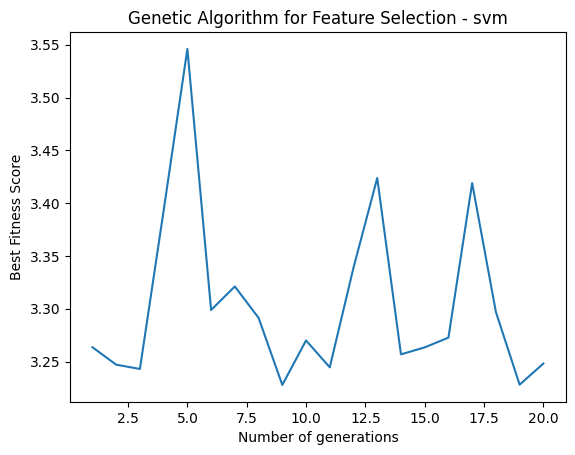

Best features selected for svm, classification: Index(['PMI1', 'RadiusOfGyration', 'DoubleCubicLatticeSurfaceArea',
       'GETAWAY_0', 'GETAWAY_1', 'GETAWAY_23', 'GETAWAY_57', 'GETAWAY_66',
       'GETAWAY_73', 'GETAWAY_78', 'GETAWAY_98', 'GETAWAY_99', 'GETAWAY_104',
       'GETAWAY_108', 'GETAWAY_131', 'GETAWAY_135', 'GETAWAY_140',
       'GETAWAY_149', 'GETAWAY_150', 'GETAWAY_157', 'GETAWAY_167',
       'GETAWAY_188', 'GETAWAY_190', 'GETAWAY_192', 'GETAWAY_212',
       'GETAWAY_213', 'GETAWAY_215', 'GETAWAY_218', 'GETAWAY_234',
       'GETAWAY_244', 'GETAWAY_250', 'WHIM_1', 'WHIM_12', 'WHIM_17', 'WHIM_37',
       'WHIM_55', 'WHIM_58', 'WHIM_76', 'WHIM_80', 'WHIM_100', 'WHIM_103',
       'WHIM_105', 'MORSE_9', 'MORSE_10', 'MORSE_22', 'MORSE_33', 'MORSE_42',
       'MORSE_73', 'MORSE_87', 'MORSE_95', 'MORSE_109', 'MORSE_122',
       'MORSE_125', 'MORSE_132', 'MORSE_133', 'MORSE_136', 'MORSE_146',
       'MORSE_158', 'MORSE_165', 'MORSE_167', 'MORSE_184', 'MORSE_212',
       'MORSE_216

Progress for svm:  41%|████████████████████████████████████████████████▉                                                                       | 20/49 [01:51<02:41,  5.57s/gen]

Early stopping triggered at generation 21.


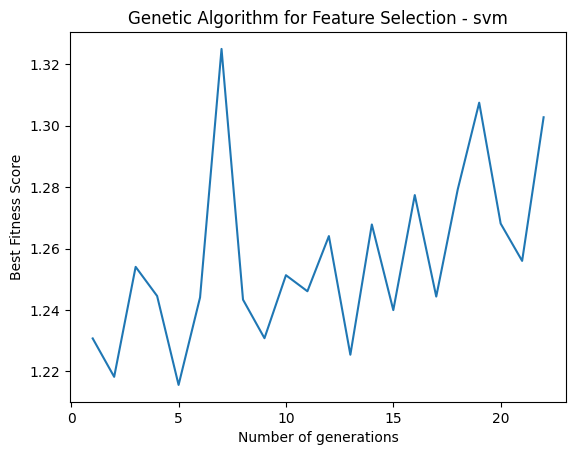

Best features selected for svm, regression: Index(['GETAWAY_8', 'GETAWAY_13', 'GETAWAY_23', 'GETAWAY_45', 'GETAWAY_72',
       'GETAWAY_78', 'GETAWAY_98', 'GETAWAY_100', 'GETAWAY_103', 'GETAWAY_105',
       'GETAWAY_114', 'GETAWAY_119', 'GETAWAY_120', 'GETAWAY_133',
       'GETAWAY_138', 'GETAWAY_143', 'GETAWAY_149', 'GETAWAY_154',
       'GETAWAY_172', 'GETAWAY_178', 'GETAWAY_182', 'GETAWAY_190',
       'GETAWAY_202', 'GETAWAY_235', 'GETAWAY_242', 'GETAWAY_261',
       'GETAWAY_267', 'WHIM_6', 'WHIM_28', 'WHIM_33', 'WHIM_73', 'WHIM_84',
       'WHIM_96', 'WHIM_100', 'WHIM_108', 'MORSE_9', 'MORSE_16', 'MORSE_34',
       'MORSE_44', 'MORSE_50', 'MORSE_61', 'MORSE_63', 'MORSE_73', 'MORSE_92',
       'MORSE_103', 'MORSE_106', 'MORSE_110', 'MORSE_116', 'MORSE_127',
       'MORSE_133', 'MORSE_134', 'MORSE_140', 'MORSE_149', 'MORSE_174',
       'MORSE_183', 'MORSE_189', 'MORSE_193', 'MORSE_194', 'MORSE_200',
       'MORSE_208', 'RDF_29', 'RDF_34', 'RDF_46', 'RDF_57', 'RDF_60', 'RDF_70',
    

Progress for linear_regression:  41%|███████████████████████████████████████████▎                                                              | 20/49 [01:14<01:48,  3.74s/gen]

Early stopping triggered at generation 21.


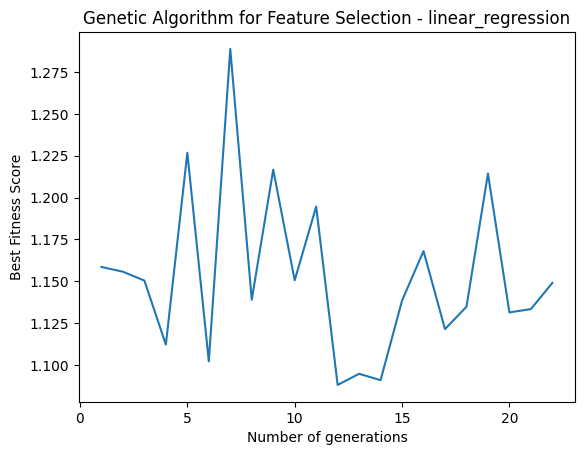

Best features selected for linear_regression, regression: Index(['DoubleCubicLatticePackingDensity', 'GETAWAY_13', 'GETAWAY_16',
       'GETAWAY_20', 'GETAWAY_26', 'GETAWAY_34', 'GETAWAY_52', 'GETAWAY_54',
       'GETAWAY_57', 'GETAWAY_64', 'GETAWAY_66', 'GETAWAY_67', 'GETAWAY_68',
       'GETAWAY_105', 'GETAWAY_110', 'GETAWAY_112', 'GETAWAY_117',
       'GETAWAY_130', 'GETAWAY_147', 'GETAWAY_151', 'GETAWAY_152',
       'GETAWAY_160', 'GETAWAY_170', 'GETAWAY_171', 'GETAWAY_187',
       'GETAWAY_189', 'GETAWAY_203', 'GETAWAY_205', 'GETAWAY_210',
       'GETAWAY_237', 'GETAWAY_265', 'GETAWAY_266', 'GETAWAY_272', 'WHIM_2',
       'WHIM_3', 'WHIM_11', 'WHIM_37', 'WHIM_38', 'WHIM_42', 'WHIM_59',
       'WHIM_64', 'WHIM_67', 'WHIM_98', 'MORSE_8', 'MORSE_26', 'MORSE_60',
       'MORSE_64', 'MORSE_70', 'MORSE_78', 'MORSE_102', 'MORSE_123',
       'MORSE_131', 'MORSE_160', 'MORSE_169', 'MORSE_187', 'MORSE_194',
       'MORSE_201', 'MORSE_208', 'RDF_2', 'RDF_3', 'RDF_23', 'RDF_28',
       'RDF_2

Progress for random_forest: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [52:52<00:00, 64.75s/gen]


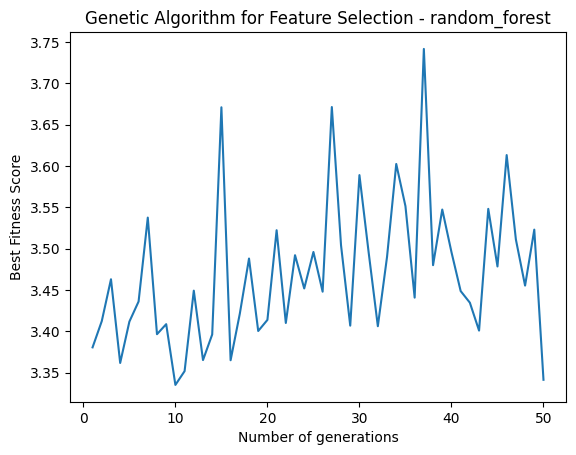

Best features selected for random_forest, classification: Index(['NPR2', 'DoubleCubicLatticeVDWVolume', 'GETAWAY_1', 'GETAWAY_6',
       'GETAWAY_23', 'GETAWAY_31', 'GETAWAY_39', 'GETAWAY_72', 'GETAWAY_87',
       'GETAWAY_91', 'GETAWAY_108', 'GETAWAY_119', 'GETAWAY_120',
       'GETAWAY_124', 'GETAWAY_131', 'GETAWAY_144', 'GETAWAY_149',
       'GETAWAY_152', 'GETAWAY_154', 'GETAWAY_156', 'GETAWAY_170',
       'GETAWAY_193', 'GETAWAY_195', 'GETAWAY_212', 'GETAWAY_232',
       'GETAWAY_239', 'GETAWAY_252', 'GETAWAY_254', 'WHIM_14', 'WHIM_24',
       'WHIM_27', 'WHIM_35', 'WHIM_39', 'WHIM_66', 'WHIM_76', 'WHIM_78',
       'WHIM_85', 'WHIM_107', 'MORSE_15', 'MORSE_22', 'MORSE_28', 'MORSE_32',
       'MORSE_38', 'MORSE_53', 'MORSE_59', 'MORSE_62', 'MORSE_67', 'MORSE_68',
       'MORSE_74', 'MORSE_105', 'MORSE_140', 'MORSE_143', 'MORSE_144',
       'MORSE_158', 'MORSE_162', 'MORSE_167', 'MORSE_174', 'MORSE_182',
       'MORSE_184', 'MORSE_198', 'MORSE_199', 'MORSE_201', 'RDF_1', 'RDF_22',
 

Progress for random_forest:  39%|████████████████████████████████████████▋                                                                | 19/49 [1:51:16<2:55:42, 351.41s/gen]

Early stopping triggered at generation 20.


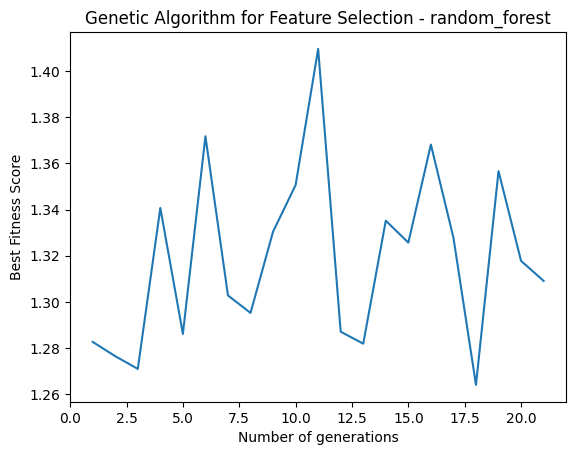

Best features selected for random_forest, regression: Index(['PMI2', 'NPR2', 'GETAWAY_5', 'GETAWAY_11', 'GETAWAY_12', 'GETAWAY_15',
       'GETAWAY_37', 'GETAWAY_48', 'GETAWAY_52', 'GETAWAY_53', 'GETAWAY_58',
       'GETAWAY_59', 'GETAWAY_77', 'GETAWAY_79', 'GETAWAY_98', 'GETAWAY_105',
       'GETAWAY_109', 'GETAWAY_110', 'GETAWAY_112', 'GETAWAY_119',
       'GETAWAY_136', 'GETAWAY_148', 'GETAWAY_149', 'GETAWAY_164',
       'GETAWAY_181', 'GETAWAY_185', 'GETAWAY_199', 'GETAWAY_207',
       'GETAWAY_223', 'GETAWAY_247', 'GETAWAY_254', 'WHIM_8', 'WHIM_18',
       'WHIM_23', 'WHIM_47', 'WHIM_64', 'WHIM_66', 'WHIM_70', 'MORSE_1',
       'MORSE_24', 'MORSE_29', 'MORSE_47', 'MORSE_50', 'MORSE_60', 'MORSE_68',
       'MORSE_73', 'MORSE_80', 'MORSE_96', 'MORSE_103', 'MORSE_105',
       'MORSE_108', 'MORSE_110', 'MORSE_121', 'MORSE_128', 'MORSE_134',
       'MORSE_150', 'MORSE_157', 'MORSE_163', 'MORSE_171', 'MORSE_178',
       'MORSE_188', 'MORSE_192', 'MORSE_204', 'MORSE_223', 'RDF_7', 'RDF_2

Progress for xgboost:  47%|████████████████████████████████████████████████████                                                           | 23/49 [1:10:31<1:19:43, 184.00s/gen]

Early stopping triggered at generation 24.


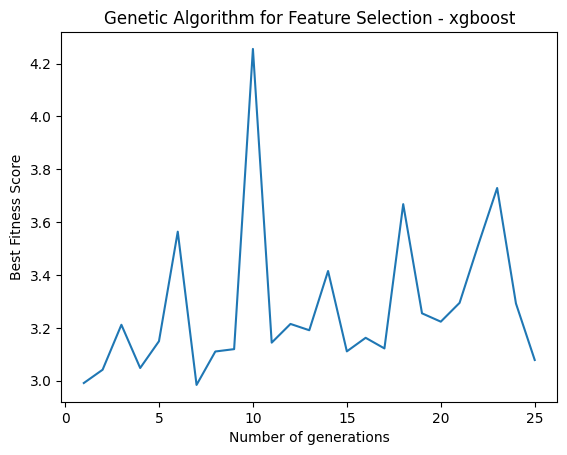

Best features selected for xgboost, classification: Index(['InertialShapeFactor', 'SpherocityIndex', 'LabuteASA', 'GETAWAY_5',
       'GETAWAY_16', 'GETAWAY_21', 'GETAWAY_35', 'GETAWAY_38', 'GETAWAY_45',
       'GETAWAY_54', 'GETAWAY_57', 'GETAWAY_62', 'GETAWAY_79', 'GETAWAY_85',
       'GETAWAY_108', 'GETAWAY_128', 'GETAWAY_135', 'GETAWAY_138',
       'GETAWAY_140', 'GETAWAY_144', 'GETAWAY_178', 'GETAWAY_182',
       'GETAWAY_187', 'GETAWAY_198', 'GETAWAY_208', 'GETAWAY_209',
       'GETAWAY_223', 'GETAWAY_226', 'GETAWAY_243', 'GETAWAY_244',
       'GETAWAY_246', 'GETAWAY_255', 'GETAWAY_263', 'WHIM_0', 'WHIM_21',
       'WHIM_24', 'WHIM_50', 'WHIM_57', 'WHIM_67', 'WHIM_73', 'WHIM_81',
       'WHIM_102', 'MORSE_3', 'MORSE_9', 'MORSE_18', 'MORSE_20', 'MORSE_23',
       'MORSE_25', 'MORSE_35', 'MORSE_45', 'MORSE_52', 'MORSE_54', 'MORSE_69',
       'MORSE_101', 'MORSE_108', 'MORSE_115', 'MORSE_143', 'MORSE_158',
       'MORSE_178', 'MORSE_186', 'MORSE_196', 'MORSE_201', 'MORSE_208',
     

Progress for xgboost:  53%|███████████████████████████████████████████████████████████▉                                                     | 26/49 [1:01:02<54:00, 140.87s/gen]

Early stopping triggered at generation 27.


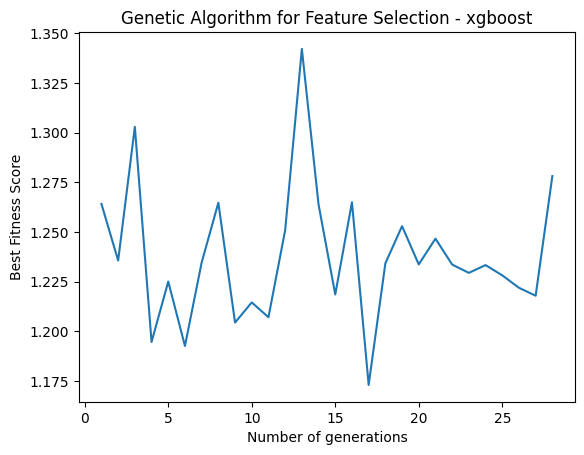

Best features selected for xgboost, regression: Index(['Asphericity', 'NPR1', 'GETAWAY_7', 'GETAWAY_15', 'GETAWAY_18',
       'GETAWAY_22', 'GETAWAY_24', 'GETAWAY_41', 'GETAWAY_55', 'GETAWAY_61',
       'GETAWAY_69', 'GETAWAY_70', 'GETAWAY_77', 'GETAWAY_82', 'GETAWAY_114',
       'GETAWAY_123', 'GETAWAY_132', 'GETAWAY_153', 'GETAWAY_154',
       'GETAWAY_160', 'GETAWAY_161', 'GETAWAY_185', 'GETAWAY_186',
       'GETAWAY_188', 'GETAWAY_192', 'GETAWAY_206', 'GETAWAY_220',
       'GETAWAY_239', 'GETAWAY_257', 'WHIM_0', 'WHIM_18', 'WHIM_21', 'WHIM_30',
       'WHIM_40', 'WHIM_68', 'WHIM_74', 'WHIM_75', 'WHIM_91', 'WHIM_92',
       'WHIM_100', 'MORSE_1', 'MORSE_7', 'MORSE_14', 'MORSE_20', 'MORSE_35',
       'MORSE_42', 'MORSE_59', 'MORSE_68', 'MORSE_92', 'MORSE_112',
       'MORSE_119', 'MORSE_120', 'MORSE_126', 'MORSE_142', 'MORSE_144',
       'MORSE_171', 'MORSE_194', 'MORSE_198', 'MORSE_209', 'MORSE_212',
       'MORSE_222', 'RDF_12', 'RDF_13', 'RDF_28', 'RDF_40', 'RDF_43', 'RDF_59',
   

In [12]:
# Loop over each model type
for model_type in model_types:
    for problem_type in problem_types:

        if problem_type == 'regression':
            X = pd.read_csv('../../3_train_test_split/train_reg.csv').set_index('Molecule ChEMBL ID') # Read input descriptors
        elif problem_type == 'classification' and model_type != 'linear_regression':
            X = pd.read_csv('../../3_train_test_split/train_class.csv').set_index('Molecule ChEMBL ID')
        else:
            print(f"Dataset train ({problem_type}) doesn't exist")
            continue

        # Load target values
        y = pd.read_csv('../../3_train_test_split/descriptors_all.csv').set_index('Molecule ChEMBL ID')
        y = y.loc[X.index, '-logIC50'] if problem_type == 'regression' else y.loc[X.index, 'Potency']

        num_features = X.shape[1]
        
        print(f'Running genetic algorithm for model: {model_type}')
        gen = 0
        population = generate_random_individuals(population_size, num_features, min_features, max_features) # Create initial population
        fitness = np.zeros(population_size)  # Fitness values for the population
        predictor_names = X.columns
    
        stagnation_counter = 0  # Tracks stagnation for early stopping
        best_fitness_i = np.zeros(max_iterations)  # Best fitness in each generation

        if model_type == 'xgboost' and problem_type == 'classification':
            # Define a mapping for the labels
            label_mapping = {
                "High Potency \n(less than 1 $\\mu$M)": 0,
                "Medium Potency \n(between 1 and 10 $\\mu$M)": 1,
                "Low Potency \n(larger than 10 $\\mu$M)": 2
            }
            # Apply the mapping to your target labels
            y = y.map(label_mapping)

        # Initial generation evaluation
        for i in range(population_size):
            fitness[i] = cross_validated_fitness(
                population[i, :], X, y, model_type, problem_type,
                k=3, alpha=1.0, beta=1.0, gamma=0.004
            )
    
        # Track the best fitness
        best_fitness_i[gen] = max(fitness)
        best_fitness_overall = max(fitness)
    
        # Genetic algorithm main loop with a progress bar
        with tqdm(total=max_iterations - 1, desc=f'Progress for {model_type}', unit='gen') as pbar:
            while gen < max_iterations - 1:
                gen += 1
    
                # Select parents based on fitness
                parents = choose_parents(population, fitness, elite_percent)
    
                # Generate offspring through crossover and mutation
                children = one_point_crossover(parents, elite_percent, mutation_probability, min_features, max_features)
                population = children
    
                # Evaluate new population
                for ind in range(population_size):
                    fitness[ind] = cross_validated_fitness(
                        population[ind, :], X, y, model_type, problem_type,
                        k=3, alpha=1.0, beta=1.0, gamma=0.004
                    )
    
                # Track the best fitness of the current generation
                best_fitness_i[gen] = max(fitness)
    
                # Re-evaluate elites periodically
                if gen % reevaluation_interval == 0:
                    fitness = reevaluate_elites(population, fitness, X, y, model_type, problem_type, k=5)
    
                # Update stagnation counter for early stopping
                if max(fitness) > best_fitness_overall:
                    best_fitness_overall = max(fitness)
                    stagnation_counter = 0  # Reset stagnation counter
                else:
                    stagnation_counter += 1
    
                # Check for early stopping
                if stagnation_counter >= patience:
                    print(f"Early stopping triggered at generation {gen}.")
                    break
    
                pbar.update(1)  # Update progress bar for each generation
    
        # Find the best feature subset from the final generation
        ind_max_fitness = np.argmax(fitness)
        best_features = population[ind_max_fitness, :]
        best_features_names = predictor_names[best_features == 1]
    
        input_dir = "."
        output_dir = model_type
        descriptor_file = "../../3_train_test_split/descriptors_all.csv"        
        process_and_save_all_files(input_dir, output_dir, best_features_names, descriptor_file, model_type, problem_type)
        
        # Plot the best fitness over generations
        plt.plot(range(1, gen + 2), best_fitness_i[:gen + 1])
        plt.xlabel('Number of generations')
        plt.ylabel('Best Fitness Score')
        plt.title(f'Genetic Algorithm for Feature Selection - {model_type}')
        plt.savefig(f'plots/genetic_algorithm_plot_{model_type}_{problem_type}.png', dpi=150)
        plt.show()
    
        print(f"Best features selected for {model_type}, {problem_type}: {best_features_names}")
    